In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights

In [53]:

from torchvision.models import resnet50, ResNet50_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
print(model)
# Inspect available attributes on the weights object
# Inspect the transforms provided by weights.transforms()
# transforms_obj = weights.transforms()

# print("\nTransforms:\n", transforms_obj.mean)

# for w in EfficientNet_B0_Weights:
#     print (w)
#     print (w.transforms().std)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
# Train-Test Split
train_dataset = datasets.EMNIST(root='../data/', train=True, split="byclass", transform=transforms.ToTensor(), download=True)
test_dataset = datasets.EMNIST(root='../data/', train=False, split="byclass", transform=transforms.ToTensor(), download=True)

In [5]:
# Label Zuordnung:
label_idx_to_char = {}
with open('../data/EMNIST/raw/emnist-byclass-mapping.txt') as f:
    for line in f:
        idx, ascii_code = map(int, line.strip().split())
        label_idx_to_char[idx] = chr(ascii_code)

# Beispiel: Zeige Label‑Index 10, 36 und 48
for idx in [0, 9, 10, 22, 36, 48]:
    print(idx, '→', label_idx_to_char[idx])  # Erwartet: 10→A, 36→a, 48→?, je nach Zeile

0 → 0
9 → 9
10 → A
22 → M
36 → a
48 → m


In [6]:
# Labelstruktur:
# 0-9: 0-9
# 10-35: A-Z
# 36-61: a-z

# relevante Labels:
valid_labels = list(range(0, 10)) + list(range(10, 23)) + list(range(36, 49))

### Jede Klasse soll genau 5000 Trainingssamples und 1000 Testsamples haben

In [36]:
from collections import defaultdict

# 2) Hilfsfunktion: Klassen‐Indizes sammeln
def collect_indices_per_class(dataset):
    label_to_img_index = defaultdict(list)
    if hasattr(dataset, 'targets'):
        labels = dataset.targets
    else:
        labels = torch.tensor([dataset[i][1] for i in range(len(dataset))])
    for idx, label in enumerate(labels):
        label_to_img_index[int(label)].append(idx)
    return label_to_img_index

train_idxs = collect_indices_per_class(filtered_test_dataset)

### Augmentierungen

LABEL ['I', 'a', '0', '3', 'X', 'U', 'O', 'e', '5', '8']


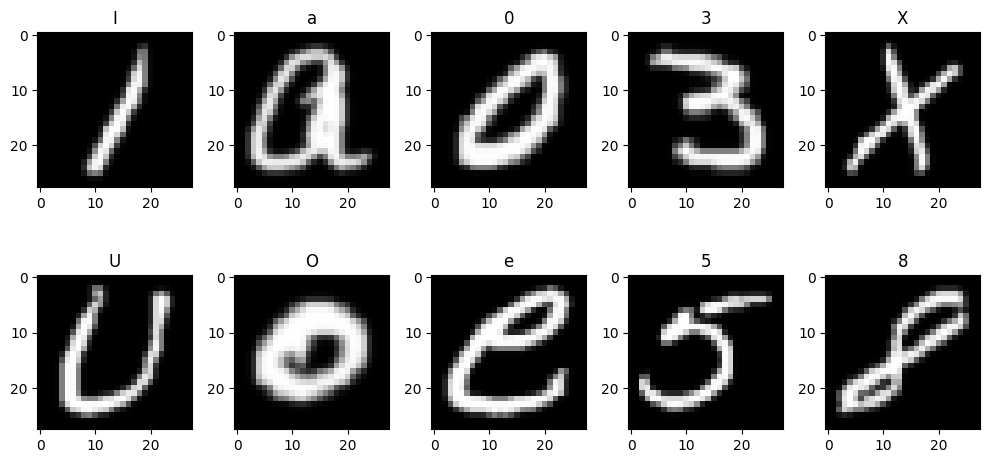

LABEL ['2', '4', '2', 'l', '2', '3', '7', 'W', '7', '5']


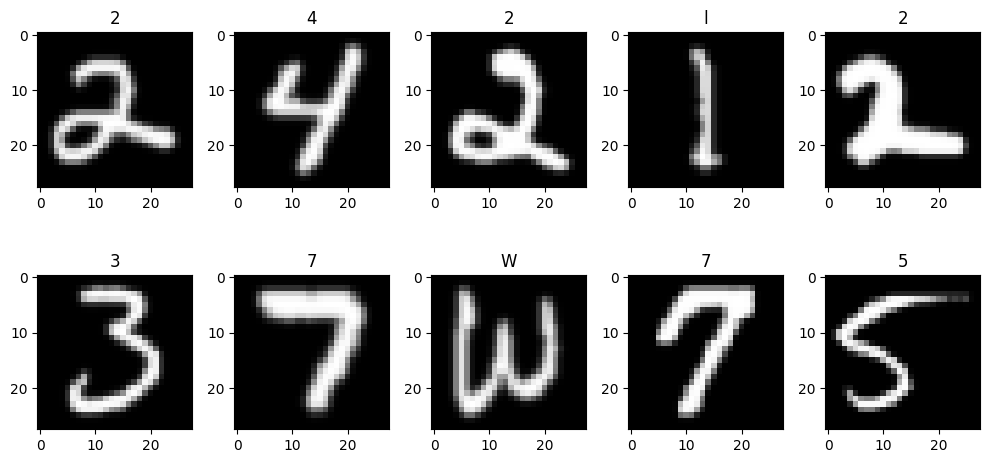

LABEL ['3', 'y', 'I', 'k', 'I', 'a', 'x', 'C', 'b', '7']


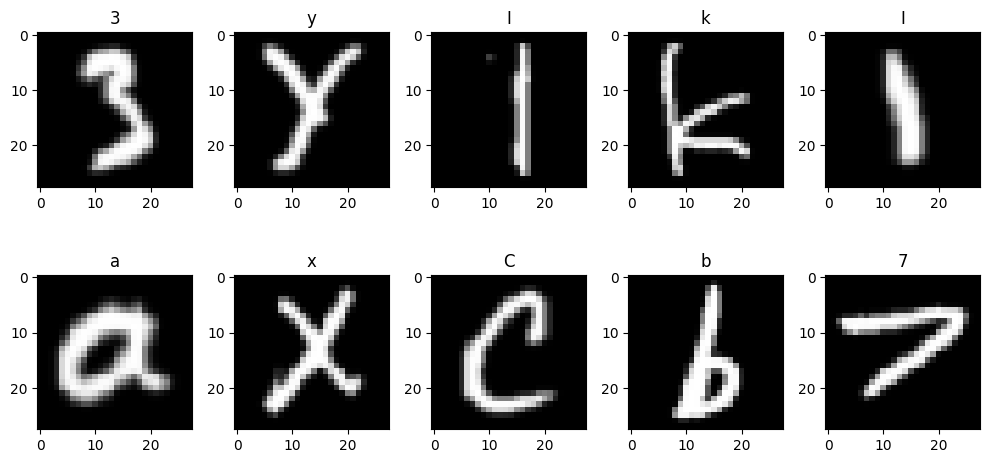

In [17]:
from torchvision.transforms import v2
import torchvision.transforms as transforms
from PrepareData import PrepareData

# transforms_obj = EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

transform = transforms.Compose([
    # transforms.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((224, 224)),


    # v2.RandomRotation(degrees=(-15, -15)),

    # verschiebt die Zeichen
    # transforms.RandomAffine(degrees=0, translate=(0.5, 0.5)),

    # sehr sehr gut, evtl. sogar besser als RandomResizedCrop
    # transforms.RandomAffine(degrees=0, scale=(0.7, 1.2)),
    # sehr gute kombi
    # transforms.RandomAffine(degrees=0, scale=(0.7, 1.2), translate=(0.05, 0.15)),

    # sehr gut, evtl. 0.85 nehmen, 0.8 sollte aber auch klappen
    # v2.RandomResizedCrop(size=(28, 28), scale=(0.8, 1)),

    # für Robusteres Modell und Störezeichen
    # v2.RandomErasing(p=0.5, scale=(0.01, 0.02), value=1),
    # v2.RandomErasing(p=0.5, scale=(0.01, 0.02), value=0),

    v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
    # v2.Normalize(
    #             mean=transforms_obj.mean,
    #             std=transforms_obj.std
    #         )
    # v2.Normalize(mean=[0.5], std=[0.5])
])
test_dataset = datasets.EMNIST(root='../data/', train=False, split="byclass", transform=transform, download=True)

# Funktion, um Labels zu char-Mapping zu konvertieren
def map_labels_to_char(labels, label_idx_to_char):
    return [label_idx_to_char[label.item()] for label in labels]



# Visualisierung
num_batches = 3
test_loader  = DataLoader(test_dataset, batch_size=10, shuffle=False)
label_idx_to_char = PrepareData.get_char_from_label()

for batch_idx, (img, label) in enumerate(test_loader):
    print ("LABEL", map_labels_to_char(label, label_idx_to_char) )
    fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(10,5))
    for i in range(10):
        axs[i//5][i%5].imshow(img[i][0].squeeze().numpy().T, cmap='gray')
        axs[i//5][i%5].set_title(label_idx_to_char[label[i].item()])

    plt.show()

    if (batch_idx + 1) == num_batches:
        break

In [14]:
import random


class OneOf:
    def __init__(self, transforms, probabilities=None):
        """
        Args:
            transforms (list): Liste von Transformationsoperationen.
            probabilities (list, optional): Wahrscheinlichkeiten für jede Transformation.
                                            Wenn None, wird jede gleich wahrscheinlich gewählt.
        """
        self.transforms = transforms
        self.probabilities = probabilities

    def __call__(self, image):
        # Wähle eine Transformation basierend auf den Wahrscheinlichkeiten
        transform = random.choices(self.transforms, weights=self.probabilities, k=1)[0]
        return transform(image)


# Definiere mögliche Augmentierungen
augmentations = [
    v2.RandomRotation(degrees=(-20, 20)),

    # verschiebt die Zeichen
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    # sehr sehr gut, evtl. sogar besser als RandomResizedCrop
    transforms.RandomAffine(degrees=0, scale=(0.4, 1.2)),
    # sehr gute kombi
    transforms.RandomAffine(degrees=0, scale=(0.4, 0.5), translate=(0.2, 0.3)),

    # sehr gut, evtl. 0.85 nehmen, 0.8 sollte aber auch klappen
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),

    # für Robusteres Modell und Störezeichen
    v2.RandomErasing(p=0.5, scale=(0.01, 0.02), value=1),
    v2.RandomErasing(p=0.5, scale=(0.01, 0.02), value=0),
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(10.5, 10.5)),
]

# Wahrscheinlichkeiten für die Augmentierungen, werden intern neu skaliert
probabilities = [1, 1, 1, 1,1,1,1,1]  # 60% für die erste, 30% für die zweite, 10% für die dritte

# Verwende die angepasste OneOf-Klasse
transform = v2.Compose([
    OneOf(augmentations, probabilities=probabilities),
])